In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import copy
import os


import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
import copy
import os
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

In [12]:
#Technical indicators list. TODO: put these in a config file


TECHNICAL_INDICATORS_LIST = ["macd", "macds",
                             "boll_ub","boll_lb", 
                             "rsi_14", "cci_14", "dx_14",
                             "open_14_sma", "pdi", "mdi",
                            "dx", "adx", "vr", "wr_14"]

In [48]:
top_dir = 'perc_changes/'
tickers = ['JNJ', 'JPM', 'DIS', 'HD']

In [49]:
def sharpe_ratio(vec):
    rets = np.divide(vec[1:] - vec[:-1], vec[:-1])
    return np.sqrt(252)*rets.mean()/rets.std()

In [50]:
#Helper function to perform softmax
def softmax(x):
    return np.exp(x)/sum(np.exp(x))


INITIAL_BALANCE = 1000.0 #Start with balance of 1000 dollars
NUM_PAST_STATES = 15 #use past 14 days of price data as part of observation
EPISODE_LENGTH = 30 #each episode goes for 30 trading days
TRADE_FREQ = 1 #Trade every x amount of days

#OpenAI Gym style environment for RL
class TradeEnv(gym.Env):
    def __init__(self, tickers):
        super(TradeEnv, self).__init__()

        self.tickers = tickers
        
        #data_idx = np.random.randint(0, 99)
        self.data_file = pickle.load(open('fake_data/test_ta_true.p', 'rb'))
        
        self.feature_names = list(self.data_file[list(self.data_file.keys())[0]].keys())
        self.feature_names.remove('date')
        self.feature_names.remove('tic')
        self.feature_names.remove('price')

            


        self.means = pickle.load(open(top_dir + 'feature_means', 'rb'))
        self.stds = pickle.load(open(top_dir + 'feature_stds', 'rb'))

        self.perc_means = pickle.load(open(top_dir + 'perc_means', 'rb'))
        self.perc_stds = pickle.load(open(top_dir + 'perc_stds', 'rb'))

        self.episode_length = EPISODE_LENGTH #number of trading minutes in episode

        self.num_past_states = NUM_PAST_STATES #number of past days that are used in state

        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers) + 1,))
                                            

        obs_length = len(self.tickers)*(self.num_past_states - 1) #observation due to past stacked states
        obs_length += 1 #balance
        obs_length += len(self.tickers) #holdings
        obs_length += len(self.tickers)*len(self.feature_names) #number of technical analysis features
        obs_length += len(self.tickers)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(obs_length,))

        self.trade_pen_frac = 0*.00002
        
    def step(self, action_):
        
        #Apply softmax to RL output so that actions sum to 1
        action = softmax(10*action_)

        #Liquidate past holdings
        self.balance += np.sum(self.holdings)
        
        trade_vol = np.sum(np.abs(self.last_action - action[:len(self.tickers)])*self.balance)
        trade_pen = self.trade_pen_frac*trade_vol


        self.last_action = action[:len(self.tickers)]
        
        self.balance = self.balance - trade_pen
        
        #New Portfolio at end of day
        self.holdings = self.balance*action[:-1]
        self.balance = self.balance*action[-1]
        

        
        #Step into next day
        self.index += TRADE_FREQ
        #Get stock prices at next day
        stock_obs = self.get_stock_obs(self.index)
        self.next_prices = stock_obs[-1]
        
        #Update value of current holdings
        perc_change = np.divide(self.next_prices, self.curr_prices)
        self.holdings = np.multiply(self.holdings, perc_change)

        self.curr_prices = self.next_prices
        
        self.net_worth = self.balance + np.sum(self.holdings)
        

        rew = self.net_worth - self.last_net_worth # reward is the delta between last net worth and current net worth

        self.last_net_worth = self.net_worth
        self.steps += TRADE_FREQ
        done = (self.net_worth <= 0) or (self.steps >= self.episode_length)

        obs = self.get_obs(stock_obs, self.balance, self.holdings, self.index)
        self.cum_rew += rew

        return obs, rew, done, {}
    
    
    def get_stock_obs(self, index):

        
        ret= self.prices[index - self.num_past_states:index][self.tickers].values #stack data
        return ret

    def get_obs(self, stock_obs, balance, holdings, index):
        #Normalize stock prices for inclusion in observations
        perc_changes = np.divide(stock_obs[1:], stock_obs[:-1])[-1:]
        perc_norm = np.divide(perc_changes - self.perc_means,
                             self.perc_stds).reshape(-1,)

        
        feature_vals = np.array([])
        ix = index - 1
        #Add in features at current timestep, for each ticker
        for tic in self.tickers:
            feature_vals = np.append(feature_vals, (self.features[tic].iloc[ix][self.feature_names].values))
        
        #Form observation and normalize balance and holdings
#         balance_norm = (balance - 1000.0/(len(self.tickers) + 1))/50.0
#         holdings_norm = (holdings - 1000.0/(len(self.tickers) + 1))/50.0
        
        net_worth = balance + np.sum(holdings)
        net_worth_norm = (net_worth - 1000.0)
        holding_frac_norm = (holdings/net_worth - .5)*20
        act_norm = (self.last_action - .5)*20
        return np.concatenate([perc_norm, [net_worth_norm], holding_frac_norm, act_norm, feature_vals])


        
    def reset(self, index = None):
        
        #data_idx = np.random.randint(0, 99)
        self.data_file = pickle.load(open('fake_data/test_ta_true.p', 'rb'))
        
        for key, df in self.data_file.items():
            df['macd'] = np.divide(df['macd'], df['price'])
            df['macds'] = np.divide(df['macds'], df['price'])


            df['boll_ub'] = np.divide(df['boll_ub'], df['price'])
            df['boll_lb'] = np.divide(df['boll_lb'], df['price'])

            df['open_14_sma'] = np.divide(df['open_14_sma'], df['price'])

        self.features = {}

        self.prices = {}
        for key, value in self.data_file.items():
 
            #Normalize features to have zero mean and unit standard deviation
            self.features[key] = np.divide(value[self.feature_names] - self.means[key],
                                          self.stds[key])
            
            self.prices[key] = value['price'].values

        self.prices = pd.DataFrame.from_dict(self.prices)
        
        
        self.cum_rew = 0.0
        self.steps = 0
        if index is None:
            self.index = np.random.randint(2*NUM_PAST_STATES, len(self.prices) - EPISODE_LENGTH - 10)
        else:
            self.index = index
        #self.init_prices = self.prices[self.index-1:self.index + EPISODE_LENGTH]
        stock_obs = self.get_stock_obs(self.index)
        self.holdings = np.zeros(len(self.tickers)) #holdings of each stock in number of shares
        self.balance = INITIAL_BALANCE
        self.last_net_worth = INITIAL_BALANCE
        self.net_worth = INITIAL_BALANCE
        
        self.curr_prices = stock_obs[-1]
        
        self.last_action = np.zeros(len(self.tickers))
        
        

        obs = self.get_obs(stock_obs, self.balance, self.holdings, self.index)
        return obs  # reward, done, info can't be included



In [41]:
# these following functions were coded with reference to
# https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail

def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def init_gru_params(gru):
    for name, param in gru.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param, 0)
        elif 'weight' in name:
            nn.init.orthogonal_(param)

# this is from https://github.com/p-morais/deep-rl/blob/master/rl/distributions/gaussian.py
class DiagonalGaussian(nn.Module):
    def __init__(self, num_outputs, init_std=1, learn_std=True):
        super(DiagonalGaussian, self).__init__()

        self.logstd = nn.Parameter(
            torch.ones(1, num_outputs) * np.log(init_std),
            requires_grad=learn_std
        )

        self.learn_std = learn_std

    def forward(self, x):
        mean = x
        
#         print(self.logstd.sum())
        std = self.logstd.exp()
        
        return mean, std

    def sample(self, x, deterministic):
        if deterministic is False:
            action = self.evaluate(x).sample()
        else:
            action, _ = self(x)

        return action

    def evaluate(self, x):
        mean, std = self(x)
        output = torch.distributions.Normal(mean, std)
        return output

    

class RACModel(nn.Module):
    def __init__(self, obs_dim, act_dim, num_tickers, num_layers_1=1, num_layers_2 = 2, hidden_size=64, learn_std=True):
        super().__init__()
        
        # num tickers, time horizon, and num ta used to compute the number of inputs
        # for recurrent network, the input size to GRU is just the num tickers (prices at each timestep)
        # and input size to the actor/critic is the current cash, holdings, and technical analysis for each ticker
        # for feedforward, the input size is num tickers * time horizon
        # and input size to the actor/critic is the current cash, holdings, and technical analysis for each ticker

        # TODO changed for cartpole
        self.act_dim = act_dim
        self.obs_dim = obs_dim
        self.num_tickers = num_tickers
        self.num_layers_1 = num_layers_1

        
        self.hidden_size = hidden_size
        #self.num_layers = num_layers
        


        
        self.gru_actor = nn.GRU(self.num_tickers, hidden_size, num_layers=num_layers_1, batch_first=True)
        self.gru_critic = nn.GRU(self.num_tickers, hidden_size, num_layers=num_layers_1, batch_first=True)
            
        

        mid_layer = int(hidden_size)

        seq_2_act = [nn.Linear(hidden_size, mid_layer), nn.Tanh()]
        seq_2_obs = [nn.Linear(hidden_size, mid_layer), nn.Tanh()]
        for i in range(num_layers_2-2):
            seq_2_act.extend([nn.Linear(mid_layer, mid_layer), nn.Tanh()])
            seq_2_obs.extend([nn.Linear(mid_layer, mid_layer), nn.Tanh()])
            
        seq_2_act.extend([nn.Linear(mid_layer, self.act_dim), nn.Tanh()])
        seq_2_obs.extend([nn.Linear(mid_layer, 1)])

        self.actor = nn.Sequential(*seq_2_act)
        self.critic = nn.Sequential(*seq_2_obs)


        
        
        
        self.dist = DiagonalGaussian(self.act_dim, learn_std=learn_std)

        #self.apply(init_params)
    
    def init_hidden(self, batch_size):
        # h0 should be of shape (num_layers * num_directions, batch size, hidden_size)
        # num_layers is 1, and RNN is not bidirectional, so num_dir = 1
        # (1, batch_size, hidden size)
        h = torch.zeros(self.num_layers_1, batch_size, self.hidden_size)
        return nn.Parameter(h, requires_grad=True)

    def forward(self, obs, rnn_h_a=None, rnn_h_c=None):
        # suppose obs is just a vector of previous prices
        
        price_obs = obs[:,:self.num_tickers]
        other_obs = obs[:,self.num_tickers:]
        

        if rnn_h_a is None:
            rnn_h_a = self.init_hidden(obs.size(0))
        if rnn_h_c is None:
            rnn_h_c = self.init_hidden(obs.size(0))

        price_obs = torch.reshape(price_obs, (-1, self.num_tickers))
        
        
        gru_obs = price_obs.unsqueeze(1)
        


        obs_actor, rnn_h_a = self.gru_actor(gru_obs, rnn_h_a)

        obs_critic, rnn_h_c = self.gru_critic(gru_obs, rnn_h_c)

        obs_actor = torch.squeeze(obs_actor, 1)
        obs_critic = torch.squeeze(obs_critic, 1)
        forward_actor = self.actor(obs_actor)
        action_dist = self.dist.evaluate(forward_actor)
        
        forward_critic = self.critic(obs_critic)

        
        return action_dist, forward_critic, rnn_h_a, rnn_h_c

In [42]:
env = TradeEnv(tickers=tickers)
acmodel_kwargs = {'hidden_size': 64, 'num_layers_1': 1, 'num_layers_2': 2}
acmodel = RACModel(env.observation_space.shape[0],
                  env.action_space.shape[0],
                   len(tickers),
                  **acmodel_kwargs)
acmodel.load_state_dict(torch.load('rnn_model_old'))

<All keys matched successfully>

In [8]:
INITIAL_BALANCE = 1000.0
done = False
obs = env.reset()
net_worths = [INITIAL_BALANCE]
stock_obs = [env.get_stock_obs(env.index)[-1]]
actions = []
hidden_a = None
hidden_c = None
while not done:
    
    
    dist, _, hidden_a, hidden_c = acmodel(torch.FloatTensor(np.array([obs])), hidden_a, hidden_c)
    
    action = dist.loc.detach().numpy()[0]

    actions.append(action)
    obs, _, done, _ = env.step(action)
    net_worths.append(env.net_worth)
    stock_obs.append(env.get_stock_obs(env.index)[-1])
stock_obs = INITIAL_BALANCE*np.divide(np.array(stock_obs), stock_obs[0])
actions = np.array(actions)
print (sharpe_ratio(np.array(net_worths)))
print ([sharpe_ratio(stock_obs[:,i]) for i in range(len(tickers))])
print (net_worths[-1])

KeyError: 'JNJ'

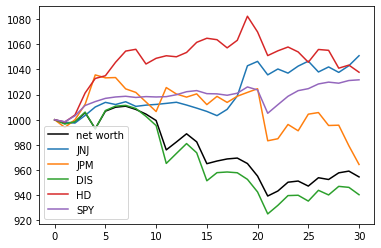

In [27]:
plt.plot(np.arange(len(net_worths)), net_worths, c = 'k', label = 'net worth')
for i in range(len(tickers)):
    plt.plot(np.arange(len(net_worths)), stock_obs[:,i], label = tickers[i])

plt.legend()

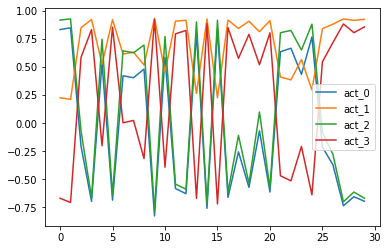

In [167]:
for i in range(len(tickers)):
    plt.plot(np.arange(len(actions)), actions[:,i], label = 'act_{}'.format(i))
plt.legend()


In [ ]:
trade

In [305]:
trade_env = TradeEnv(tickers=tickers)

net_worths_train = []
buy_and_holds = []
actions = []
np.random.seed()

for i in range(1000):
    print (i)
    INITIAL_BALANCE = 1000.0
    done = False
    obs = trade_env.reset()
    init_obs = trade_env.get_stock_obs(trade_env.index)[-1]
    hidden_a = None
    hidden_c = None
    while not done:
        dist, _, hidden_a, hidden_c = acmodel(torch.FloatTensor(np.array([obs])), hidden_a, hidden_c)

        action = dist.loc.detach().numpy()[0]

        actions.append(action)
        obs, _, done, _ = trade_env.step(action)
    net_worths_train.append(trade_env.net_worth)
    buy_and_holds.append(1000.0*np.divide(trade_env.get_stock_obs(trade_env.index)[-1],
                                         init_obs))
buy_and_holds = np.array(buy_and_holds)
    


0


KeyError: 'SPY'

In [169]:
np.mean(net_worths_train)

1007.2380460431525

In [349]:
spy_vals = TradeEnv(tickers=tickers + ['SPY']).data_file['SPY'][50:750][['date', 'price']]

In [351]:
spy_vals[30:30+253]

,date,price
80,2017-05-11,239.089996
81,2017-05-12,239.470001
82,2017-05-15,240.639999
83,2017-05-16,240.080002
84,2017-05-17,235.729996
...,...,...
328,2018-05-07,266.500000
329,2018-05-08,267.679993
330,2018-05-09,270.339996
331,2018-05-10,272.160004


In [343]:
ann_returns = []
for i in range(459):
    ann_returns = spy_vals[i+241]/spy_vals[i]

In [344]:
np.mean(ann_returns)

1.2279658960501911

In [65]:
trade_env.data_file['DIS'][50:500]

,date,tic,day,volume,macd,macds,boll_ub,boll_lb,rsi_14,cci_14,dx_14,open_14_sma,pdi,mdi,dx,adx,vr,wr_14,price
50,2017-03-29,DIS,2,3781200,0.005991,0.006242,1.006305,0.979797,59.769160,95.644602,42.082448,0.995671,25.771849,10.505466,42.082448,36.500760,190.944047,27.843151,112.529999
51,2017-03-30,DIS,3,4192800,0.006142,0.006201,1.003146,0.976828,62.787198,130.740649,49.741848,0.992244,27.091916,9.092913,49.741848,40.283928,188.350465,12.096881,113.000000
52,2017-03-31,DIS,4,4617400,0.006327,0.006218,1.002754,0.976200,63.904018,175.812669,57.182780,0.991979,29.439103,8.019330,57.182780,45.112171,222.186217,20.703097,113.180000
53,2017-04-03,DIS,0,4643300,0.006388,0.006254,1.003717,0.977927,63.561644,111.767041,29.191458,0.993157,25.087947,13.750452,29.191458,40.563396,191.199063,21.874925,113.150002
54,2017-04-04,DIS,1,3386100,0.006640,0.006312,1.001266,0.975261,66.345021,124.058782,29.191458,0.989850,22.189456,12.161818,29.191458,37.314271,190.867517,5.138234,113.580002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2019-01-04,DIS,4,10122800,-0.014131,-0.017429,1.058962,0.928473,49.835092,44.910508,2.785340,0.981186,28.217333,26.688032,2.785340,15.153288,68.867866,29.550439,109.910004
496,2019-01-07,DIS,0,6714700,-0.010380,-0.015783,1.038126,0.913869,54.336444,98.942409,8.865257,0.963027,28.092662,23.517306,8.865257,13.356708,68.411814,8.692155,111.800003
497,2019-01-08,DIS,1,8730700,-0.007510,-0.014129,1.037897,0.913927,54.336444,126.820073,19.262777,0.962714,31.181475,21.108898,19.262777,15.044156,63.139885,6.224362,111.800003
498,2019-01-09,DIS,2,5931900,-0.005032,-0.012290,1.034789,0.912849,54.809206,123.210268,21.403505,0.961674,29.352072,19.002499,21.403505,16.861113,59.765956,6.506063,111.989998


In [71]:
agent_sharpe_ratios = [sharpe_ratio(n) for n in net_worths_365]
print (np.mean(agent_sharpe_ratios), np.std(agent_sharpe_ratios))
stock_sharpe_ratios = np.array([[sharpe_ratio(n) for n in stock_worths_365[:,:,i]]
                             for i in range(4)])

1.0338646463763324 0.8500430992252148


In [82]:
for i in range(4):
    print (np.mean(stock_sharpe_ratios[i]), np.std(stock_sharpe_ratios[i]))

0.12852431121513677 0.41777510004856405
0.544271381111348 0.6877977210400192
0.6661020115436845 0.5957503708771862
0.7421582574820751 0.6152972981149553


In [85]:
print (np.mean(stock_sharpe_ratios), np.std(stock_sharpe_ratios))

0.520263990338061 0.6335718455684258


In [51]:
net_worths_365 = []
stock_worths_365 = []
for i in range(50, 500):
    print (i)
    INITIAL_BALANCE = 1000.0
    trade_env = TradeEnv(tickers=tickers)

    done = False
    obs = trade_env.reset(i)
    net_worths = [INITIAL_BALANCE]
    stock_obs = [trade_env.get_stock_obs(trade_env.index)[-1]]
    last_base = INITIAL_BALANCE
    j = 0
    actions = []
    hidden_a = None
    hidden_c = None
    while j < 253 - 30:
        obs = trade_env.reset(i + j)
        done = False


        while not done:
            dist, _, hidden_a, hidden_c = acmodel(torch.FloatTensor(np.array([obs])), hidden_a, hidden_c)

            action = dist.loc.detach().numpy()[0]

            actions.append(action)
            obs, _, done, _ = trade_env.step(action)
            net_worths.append(trade_env.net_worth*(last_base/INITIAL_BALANCE))
            stock_obs.append(trade_env.get_stock_obs(trade_env.index)[-1])
            j += 1
        last_base = net_worths[-1]

    stock_obs = INITIAL_BALANCE*np.divide(np.array(stock_obs), stock_obs[0])
    actions = np.array(actions)
    net_worths_365.append(net_worths)
    stock_worths_365.append(stock_obs)
stock_worths_365 = np.array(stock_worths_365)
#     print (sharpe_ratio(np.array(net_worths)))
#     print ([sharpe_ratio(stock_obs[:,i]) for i in range(len(tickers))])
#     print (net_worths[-1])


50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
31

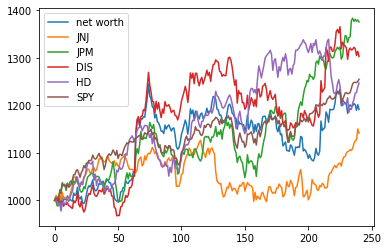

In [29]:
plt.plot(np.arange(len(net_worths)), net_worths, label = 'net worth')
for i in range(len(tickers)):
    plt.plot(np.arange(len(net_worths)), stock_obs[:,i], label = tickers[i])

plt.legend()

In [52]:
net_worths_365 = np.array(net_worths_365)

In [53]:
np.mean(net_worths_365[:,-1])

1189.372255403546

In [66]:
np.mean(np.mean(stock_worths_365[:,-1,], axis = 0))

1092.2318969928442

In [55]:
net_worths_365.shape

(450, 241)

In [56]:
stock_worths_365[:,:,0].shape

(450, 241)

In [57]:
data_dict = {}
values = np.array([0])
days = np.array([0])
labels = []
for i, tic in enumerate(tickers):
    values = np.append(values, np.concatenate(stock_worths_365[:,:,i]))
    days = np.append(days, np.concatenate([np.arange(241)]*450))
    labels = labels + [tic]*450*241
values = np.append(values, np.concatenate(net_worths_365))
days = np.append(days, np.concatenate([np.arange(241)]*450))
labels = labels + ['Portfolio Value']*450*241
values = values[1:]
days = days[1:]
data_dict['values'] = values
data_dict['labels'] = labels
data_dict['days'] = days
data_df = pd.DataFrame.from_dict(data_dict)

In [58]:
data_df = data_df[data_df['labels']!= 'SPY']

In [59]:
import matplotlib

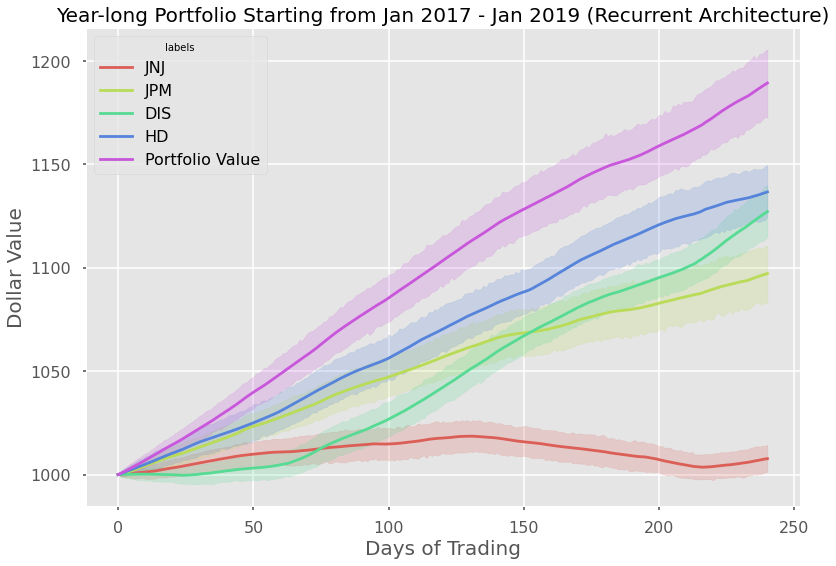

In [61]:
nums = len(data_df['labels'].unique())
palette = sns.color_palette("hls", nums)
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

fig = plt.figure()
ax = sns.lineplot(x = 'days', y = 'values', data = data_df, estimator = 'mean', palette=palette, hue='labels')

ax.set_title('Year-long Portfolio Starting from Jan 2017 - Jan 2019 (Recurrent Architecture)', fontsize = 20)
ax.set_xlabel('Days of Trading', fontsize = 20)
ax.set_ylabel('Dollar Value', fontsize = 20)

plt.show()
fig.savefig('2017_2020_trading_rec.png')

In [249]:
test_df = pd.DataFrame.from_dict({'x': np.append(np.arange(100), np.arange(100)),
          'y': np.append(np.random.normal(size = 100), np.random.normal(size = 100))})

In [35]:
import matplotlib.style as style
import seaborn as sns




In [ ]:
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

all_logs = []
all_logs.extend(fwd)
all_logs.extend(rnn)
logs = pd.concat(all_logs, ignore_index=True)
nums = len(logs['label'].unique())
palette = sns.color_palette("hls", nums)
fig = plt.figure()
ax = sns.lineplot(x='num_frames', y='smooth_reward', data=logs, estimator='mean', palette=palette, hue='label')
ax.set_title('Comparing Smooth Reward')
ax.set_xlabel('Num Frames')
ax.set_ylabel('Smooth Reward')
ax.set_ylim((-30, 90))
plt.show()
fig.savefig('ppo - 2state, 4layerac-restructured.png')

In [359]:
# torch.save(acmodel.state_dict(), 'rnn_model_old')